In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')   # suppress warning messages

In [2]:
# configure the figure format in jupyter notebook
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv('../reviews.csv', delimiter='\t', quoting=3)
df.shape

(1000, 2)

In [4]:
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [5]:
# check if there is missing values
df.isnull().sum()

Review    0
Liked     0
dtype: int64

In [6]:
# Add special tokens to separate sentences and do classification
# Pass sequences of constant length (introduce padding)
# Create array of 0s (pad token) and 1s (real token) called attention mask
# cased version of BERT
# The tokenizer will break the sentence into words and give numerical values to each word.

In [7]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [9]:
# BERT works with fixed-length sequences
# Store length of each review
token_lens = []

# Iterate through the Review slide
for txt in df.Review:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

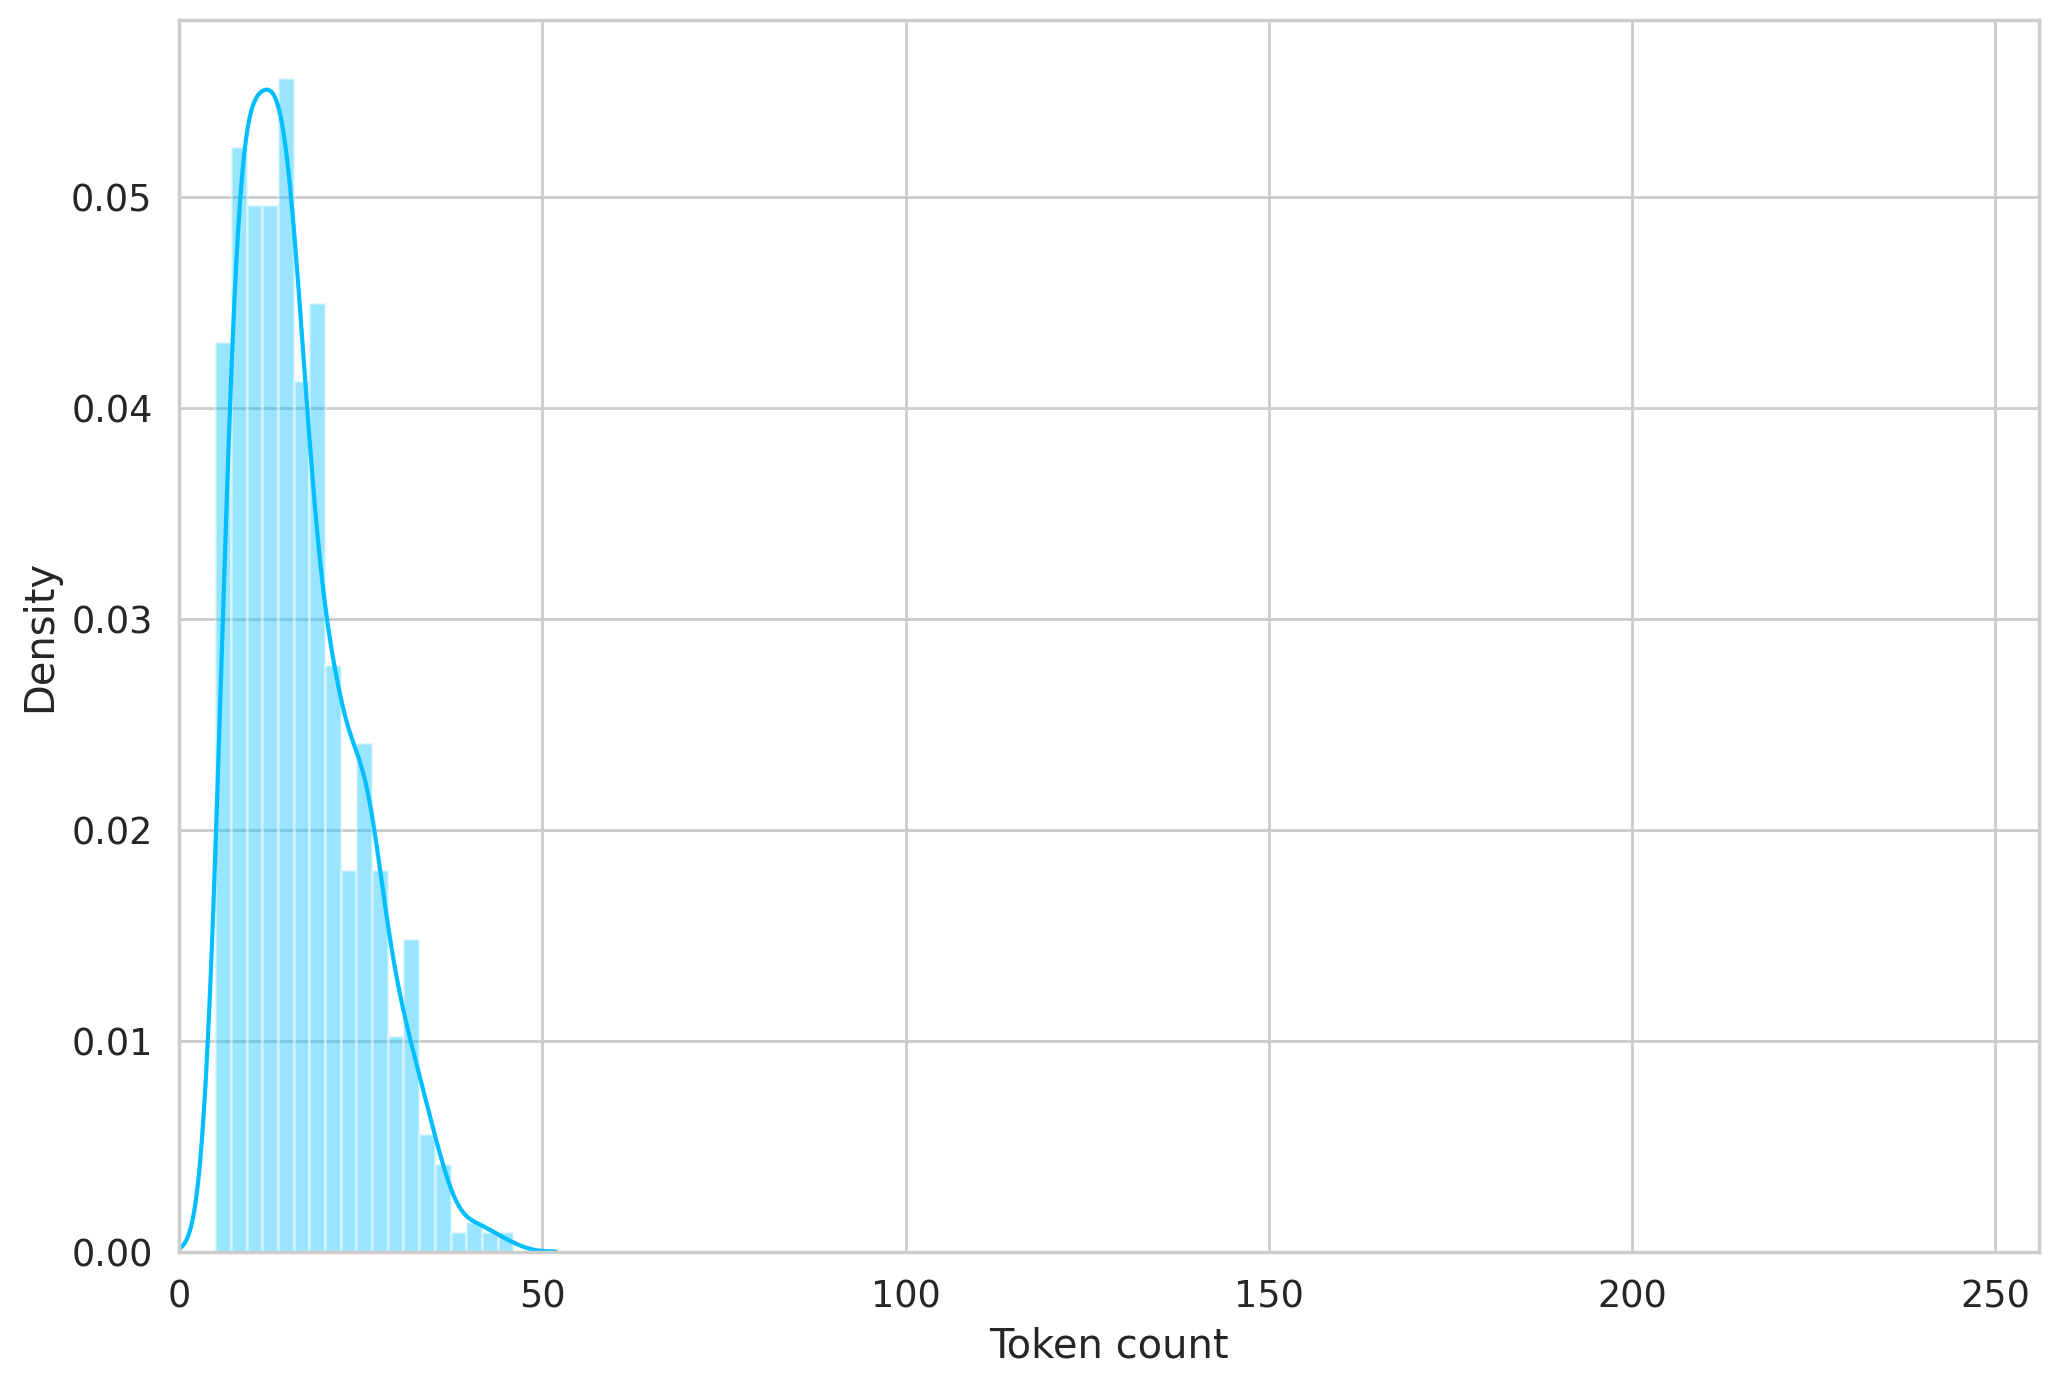

In [10]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [11]:
MAX_LEN = 60

In [12]:
class ReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length of review
    def __len__(self):
        return len(self.reviews)

    # get certain item with index
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',    # type of pytorch tensor
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [13]:
# Create a 80% train data and 10% test and 10% validation data
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(800, 2) (100, 2) (100, 2)


In [14]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ReviewDataset(
        reviews=df.Review.to_numpy(),
        targets=df.Liked.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [15]:
# Create train, test and val data loaders
BATCH_SIZE = 32
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [16]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([32, 60])
torch.Size([32, 60])
torch.Size([32])


In [17]:
# Load the basic BERT model
bert_model = BertModel.from_pretrained(MODEL_NAME)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [18]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.3) # 30% of the input units are zeroed out
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        ) # bert() contains self-attention
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)

In [19]:
# a dropout layer(prevent overfitting) for regularization and a fully-connected layer for output
# return the raw output of the last layer for the cross-entropy loss function in PyTorch

In [20]:
# Instantiate the model and move to classifier
class_names = ['negative', 'positive']
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [21]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


In [22]:
# Number of iterations
EPOCHS = 5

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [23]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()   # Sets the model to training mode
    losses = []
    correct_predictions = 0

    for d in data_loader:   # processes a batch of data
        # Forward Pass
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)    # Calculates the loss between the predicted logits (outputs) and the target labels (targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward propagation to compute the gradients of the loss with respect to the model parameters.
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clips the gradients to prevent them from exploding using gradient clipping
        optimizer.step()    # Updates the model parameters
        scheduler.step()    # Adjusts the learning rate
        optimizer.zero_grad()   # Resets the gradients to zero

    return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
# evaluation function
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()    # Sets the model to evaluation mode

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
# training loop
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * EPOCHS)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If beat prev performance, store the best training state
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
-----
Train loss 0.44519976019859314 accuracy 0.795
Val   loss 0.4977964088320732 accuracy 0.89

Epoch 2/5
-----
Train loss 0.17450277704745532 accuracy 0.94375
Val   loss 0.24198646051809192 accuracy 0.9

Epoch 3/5
-----
Train loss 0.04429554260335863 accuracy 0.9912500000000001
Val   loss 0.2550278132548556 accuracy 0.92

Epoch 4/5
-----
Train loss 0.019452699455432595 accuracy 0.99625
Val   loss 0.30800052115228027 accuracy 0.91

Epoch 5/5
-----
Train loss 0.010144243938848376 accuracy 0.9975
Val   loss 0.30041386355878785 accuracy 0.92



(0.0, 1.0)

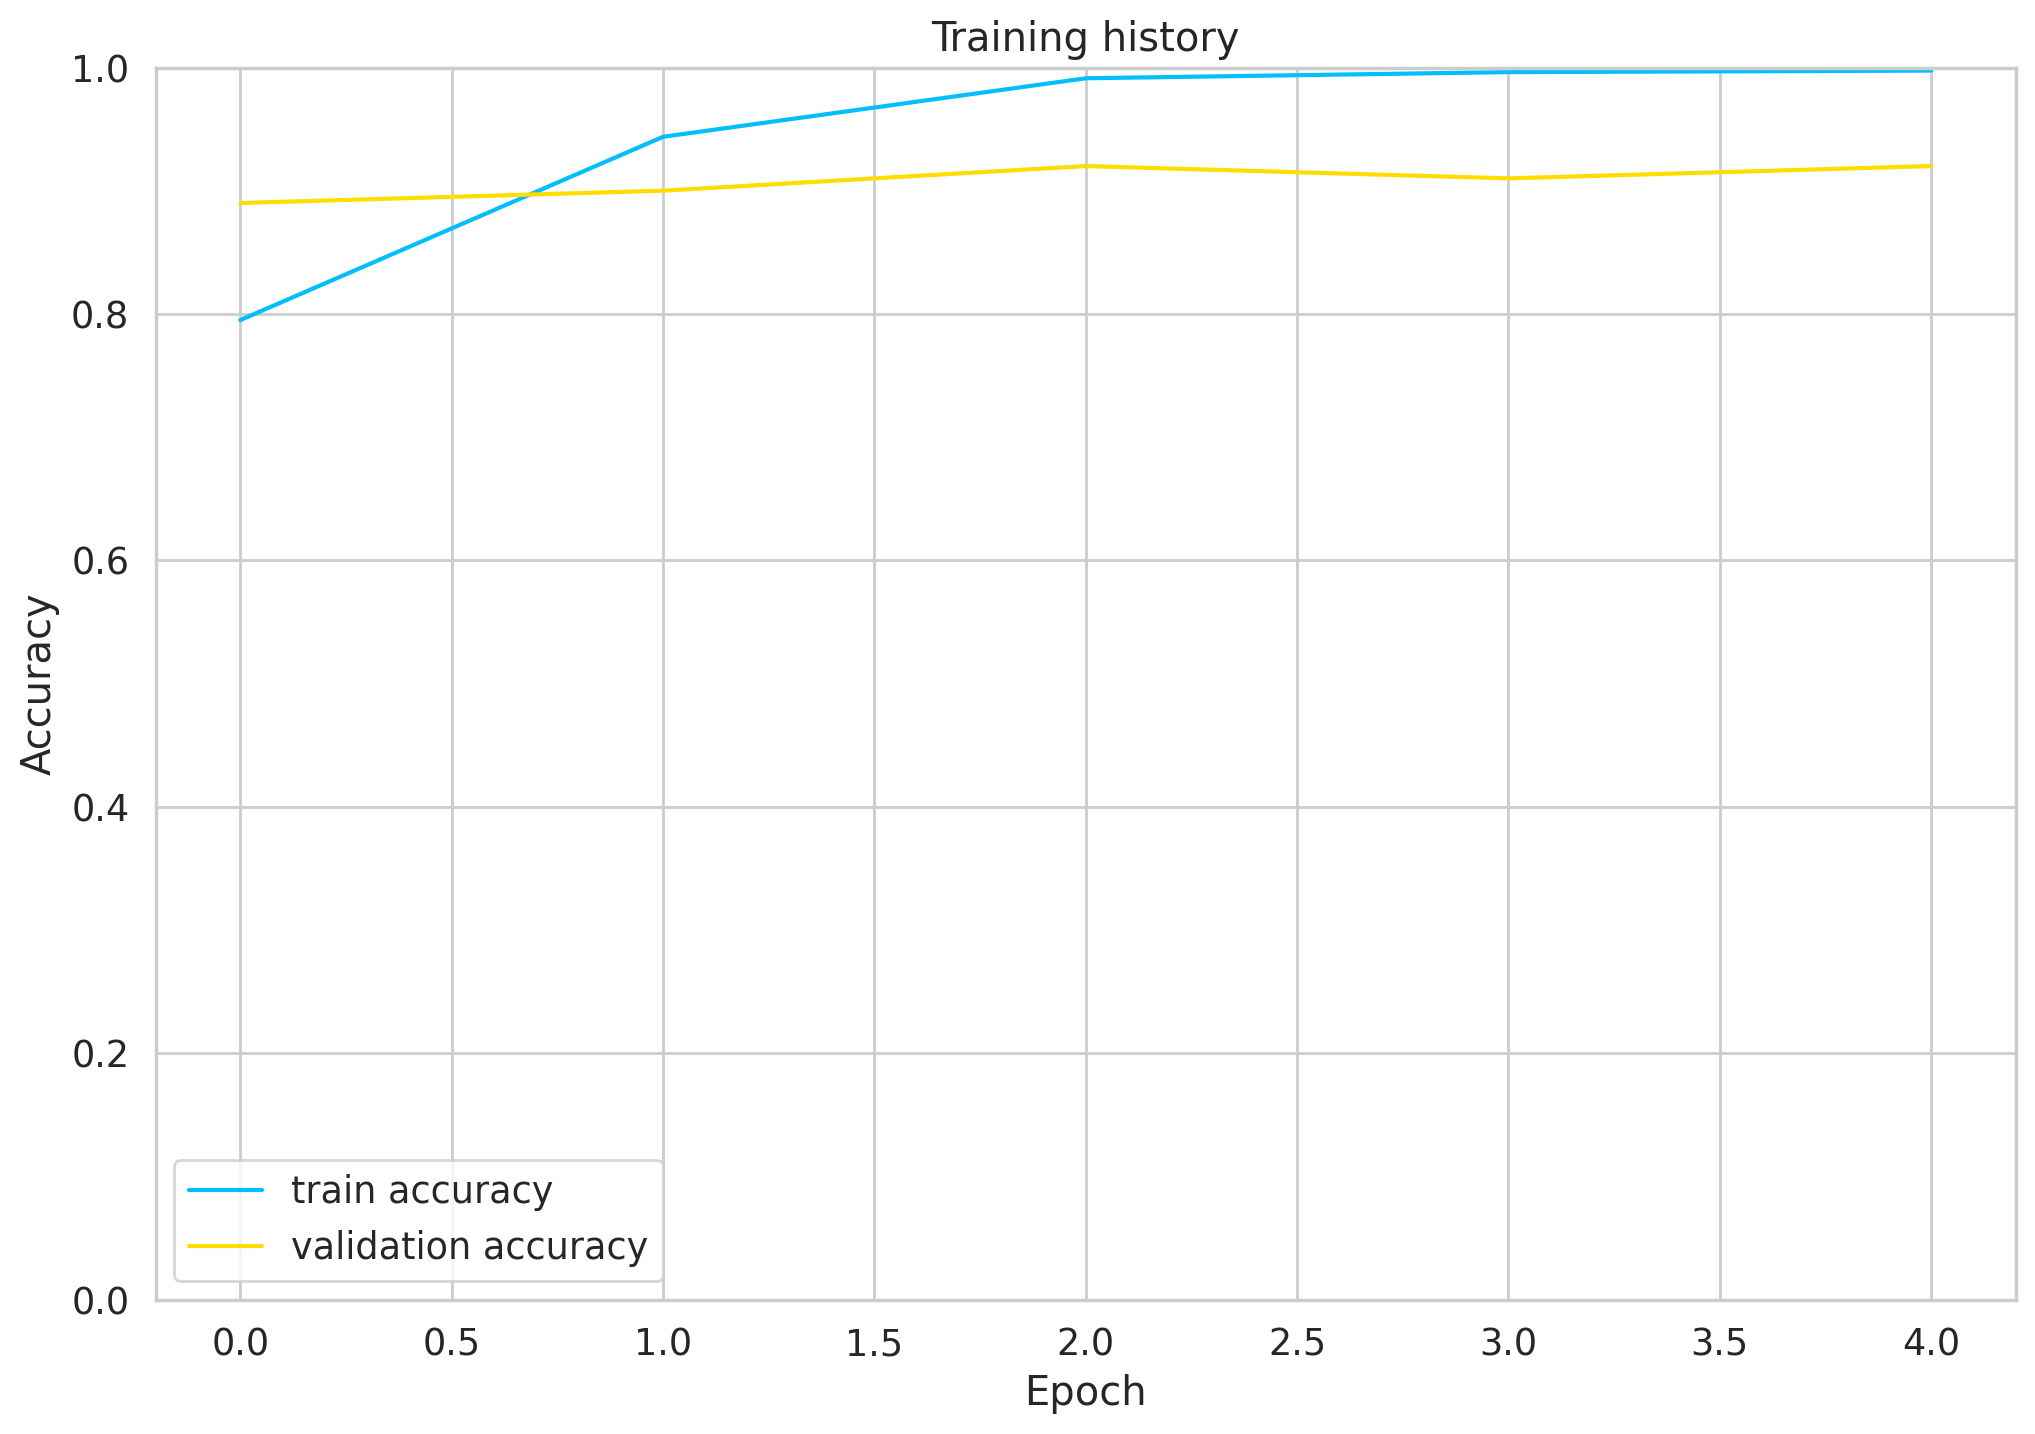

In [26]:
# Plot training and validation accuracy
plt.plot([t.item() for t in history['train_acc']], label='train accuracy')
plt.plot([t.item() for t in history['val_acc']], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [27]:
# model evaluation
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.88

In [28]:
# store the text of the reviews and the predicted probabilities
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [29]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [30]:
# AUROC
print(roc_auc_score(y_test, y_pred_probs[:, 1]))

0.9432367149758454


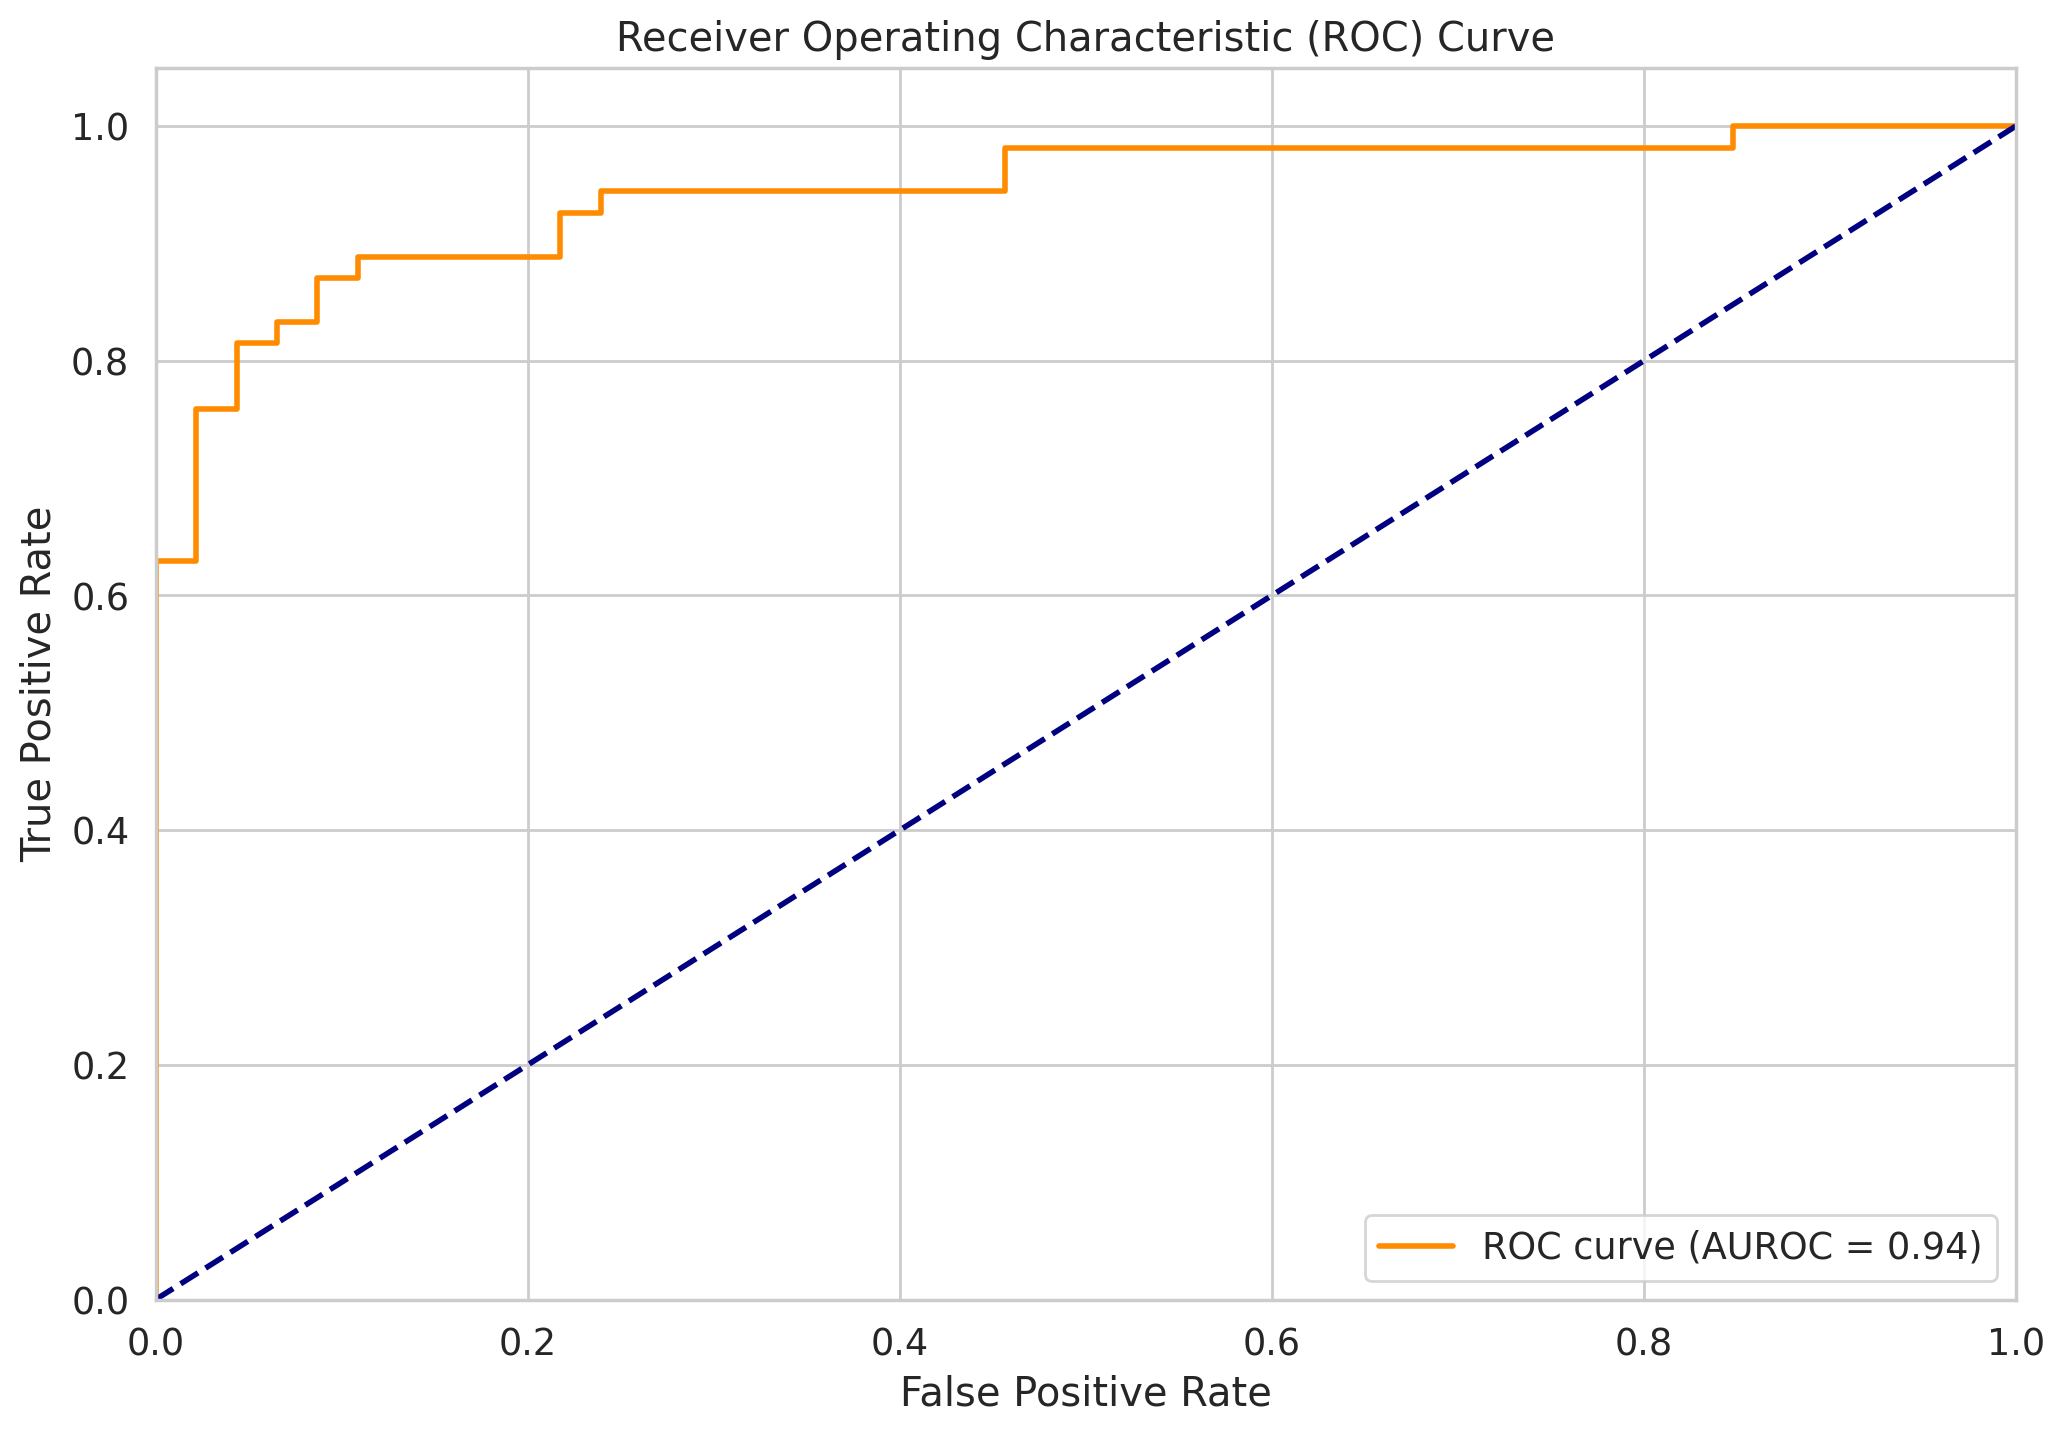

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:, 1])

# Calculate AUROC
auroc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUROC = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [32]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.85      0.89      0.87        46
    positive       0.90      0.87      0.89        54

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100



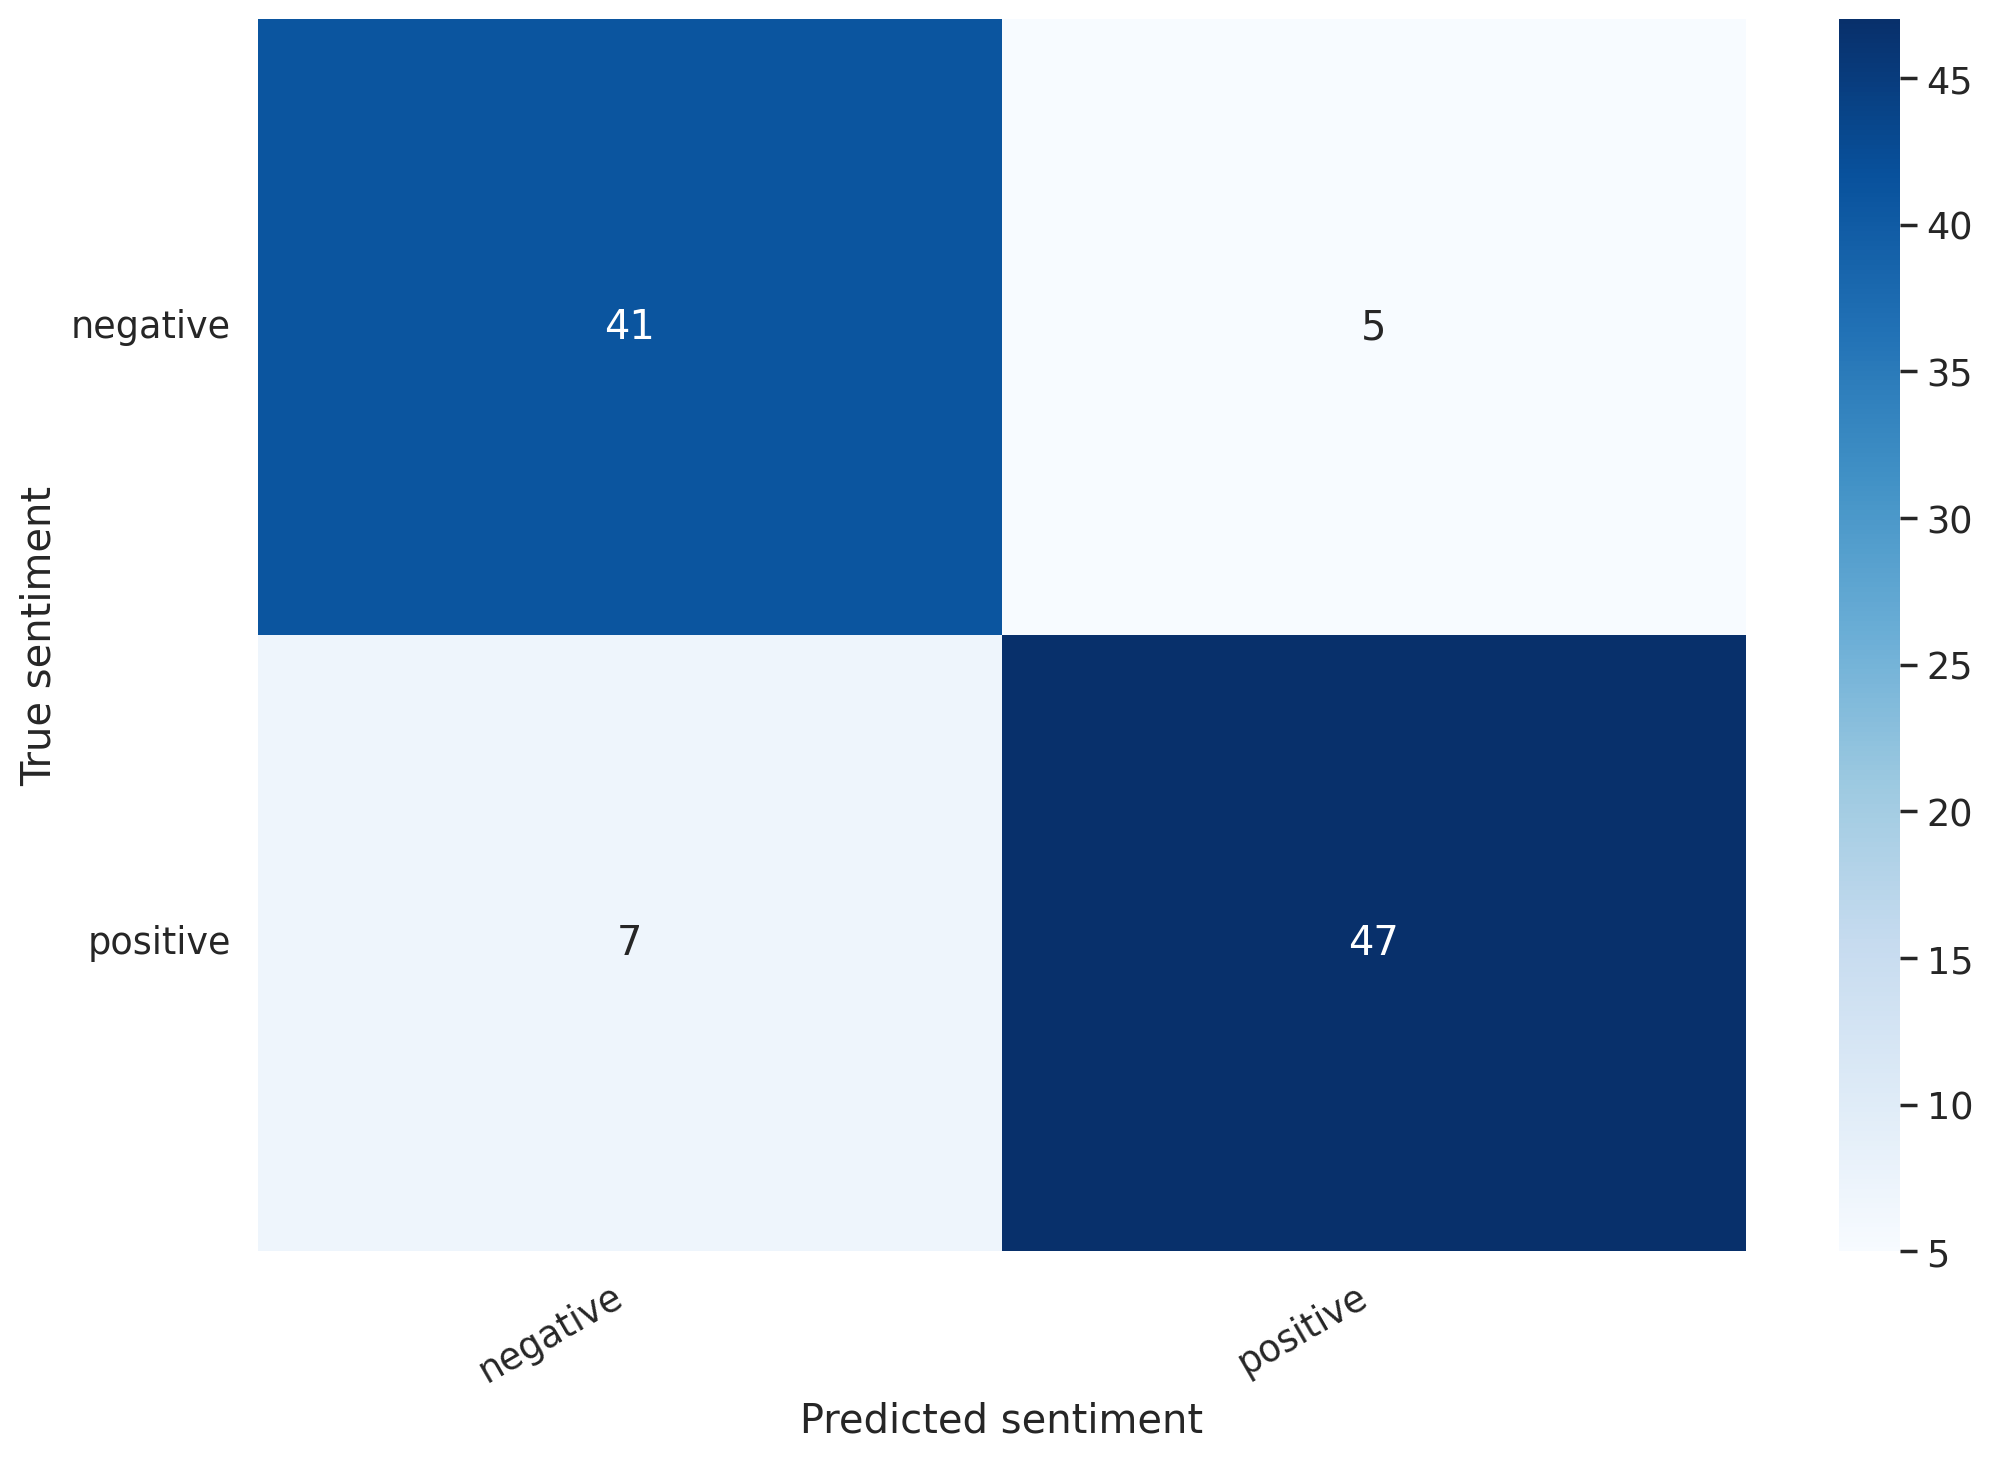

In [33]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [34]:
# Predicting on raw text
review_text = "I love this salmon! Best dish ever!!!"

In [35]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [36]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love this salmon! Best dish ever!!!
Sentiment  : positive
